# **Детекция объектов на изображении**

In [1]:
pip install torch torchvision albumentations numpy pillow tqdm torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.7 MB/s eta 0:00:00


Загрузка данных

In [2]:
!gdown "https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF" -O seminar_objdet_retina_oi5_ball.zip

Downloading...
From (original): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF
From (redirected): https://drive.google.com/uc?id=1ZMPIHcEVOZx9OukDOGvmkndkVGYpmIEF&confirm=t&uuid=6fabab7d-2be4-4750-a6a6-a8a652c83bed
To: /content/seminar_objdet_retina_oi5_ball.zip
100% 1.08G/1.08G [00:12<00:00, 84.8MB/s]


In [3]:
!unzip seminar_objdet_retina_oi5_ball.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/2688.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._2688.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1381.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1381.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0921.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0921.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0909.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._0909.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/3025.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._3025.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/1626.jpg  
  inflating: __MACOSX/seminar_objdet_retina_oi5_ball/oi5_ball/._1626.jpg  
  inflating: seminar_objdet_retina_oi5_ball/oi5_ball/0538.jpg  
  inflating: __MACOSX/seminar_objd

In [4]:
import os
import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torchvision
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Реализация класса **Dataset** для требуемых данных и выбранной модели обучения (**FasterRCNN**)

In [5]:
class BallDataset(Dataset):
    def __init__(self, root, ann_file, transforms=None):
        self.root = root
        self.transforms = transforms

        with open(ann_file, "r") as f:
            self.annotations = json.load(f)
        self.image_paths = list(self.annotations.keys())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path_rel = self.image_paths[idx]
        img_path = os.path.join(self.root, img_path_rel)
        image = Image.open(img_path).convert("RGB")
        w, h = image.size
        image = np.array(image)

        boxes = []
        labels = []
        for box in self.annotations[img_path_rel]:
            xc, yc, bw, bh = box
            if bw <= 0 or bh <= 0:
                continue
            x1 = (xc - bw / 2) * w
            y1 = (yc - bh / 2) * h
            x2 = (xc + bw / 2) * w
            y2 = (yc + bh / 2) * h
            if x2 <= x1 or y2 <= y1:
                continue
            boxes.append([x1, y1, x2, y2])
            labels.append(1)

        if self.transforms:
            transformed = self.transforms(
                image=image,
                bboxes=boxes,
                class_labels=labels
            )
            image = transformed["image"]
            raw_boxes = transformed["bboxes"]
            raw_labels = transformed["class_labels"]

            valid_boxes = []
            valid_labels = []
            for box, label in zip(raw_boxes, raw_labels):
                x1, y1, x2, y2 = box
                if x2 > x1 and y2 > y1 and (x2 - x1) >= 1.0 and (y2 - y1) >= 1.0:
                    valid_boxes.append([x1, y1, x2, y2])
                    valid_labels.append(label)

            boxes = valid_boxes
            labels = valid_labels

        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])

        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]) if boxes.numel() > 0 else torch.zeros((0,), dtype=torch.float32)
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        return image, target

Добавление простых аугментаций и аугментации, затрагивающие изменение *ground-truth bounding box*<br>
Последние закомменчены для простоты и уменьшения кол-ва ячееу, так как далее пробовал исключать некоторые аугментации.

In [17]:
DATA_DIR = "seminar_objdet_retina_oi5_ball"
IMG_DIR = DATA_DIR
TRAIN_ANN = os.path.join(DATA_DIR, "oi5_ball_filename_to_bbox_train.json")
VAL_ANN = os.path.join(DATA_DIR, "oi5_ball_filename_to_bbox_val.json")

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transform = A.Compose([
    A.Resize(480, 480),
    # A.HorizontalFlip(p=0.5),
    # A.Affine(
    #     scale=(0.9, 1.1),
    #     translate_percent=(0.05, 0.05),
    #     rotate=(-5, 5),
    #     p=0.3
    # ),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
], bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['class_labels'],
    min_area=1,
    min_visibility=0.1,
    check_each_transform=True,
    clip=True
))

val_transform = A.Compose([
    A.Resize(480, 480),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
], bbox_params=A.BboxParams(
    format='pascal_voc',
    label_fields=['class_labels'],
    check_each_transform=True,
    clip=True
))

Реализация loader'ов

In [23]:
full_train_dataset = BallDataset(root=IMG_DIR, ann_file=TRAIN_ANN, transforms=train_transform)
full_val_dataset = BallDataset(root=IMG_DIR, ann_file=VAL_ANN, transforms=val_transform)

subset_size = len(full_train_dataset) // 4
random.seed(42)
train_indices = random.sample(range(len(full_train_dataset)), subset_size)
train_dataset = Subset(full_train_dataset, train_indices)

val_dataset = full_val_dataset

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

print(f"Train subset size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

Train subset size: 718
Val size: 226


Выбор непредобученной модели asterrcnn_resnet50_fpn и гиперпараметров (оптимизатор, lr)

In [8]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=None,
    num_classes=2
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0005
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


Реализация train-loop

In [24]:
def train_model(model, train_loader, val_loader, device, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        print(f"\n===== Epoch {epoch+1}/{num_epochs} =====")
        total_loss = 0.0
        for images, targets in tqdm(train_loader, desc=f"Train {epoch+1}"):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            total_loss += losses.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Train loss: {avg_loss:.6f}")
    return model

Реализация mAP

In [25]:
def evaluate_map_on_val(model, val_loader, device):
    model.eval()
    metric = MeanAveragePrecision(iou_thresholds=[0.5])
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Evaluating mAP on Val"):
            images = [img.to(device) for img in images]
            outputs = model(images)

            outputs_cpu = [{k: v.cpu() for k, v in o.items()} for o in outputs]
            targets_cpu = [{k: v.cpu() for k, v in t.items()} for t in targets]
            metric.update(outputs_cpu, targets_cpu)
    result = metric.compute()
    print(f"\n mAP @ IoU=0.5: {result['map']:.4f}")
    return result

**Первый запуск:**<br>
Оптимизатор - SGD, lr=0.001, 25% от датасета для трейна, аугментации, затрагивающие ground-truth box убраны, 5 эпох

In [ ]:
trained_model = train_model(model, train_loader, val_loader, device, optimizer, num_epochs=5)
map_result = evaluate_map_on_val(trained_model, val_loader, device)


===== Epoch 1/5 =====


Train 1: 100%|██████████| 359/359 [02:25<00:00,  2.46it/s]


Train loss: 0.291374

===== Epoch 2/5 =====


Train 2: 100%|██████████| 359/359 [02:25<00:00,  2.47it/s]


Train loss: 0.291151

===== Epoch 3/5 =====


Train 3: 100%|██████████| 359/359 [02:25<00:00,  2.47it/s]


Train loss: 0.282628

===== Epoch 4/5 =====


Train 4: 100%|██████████| 359/359 [02:24<00:00,  2.48it/s]


Train loss: 0.280815

===== Epoch 5/5 =====


Train 5: 100%|██████████| 359/359 [02:24<00:00,  2.48it/s]


Train loss: 0.279570


Evaluating mAP on Val: 100%|██████████| 113/113 [00:20<00:00,  5.55it/s]



 mAP @ IoU=0.5: 0.1351


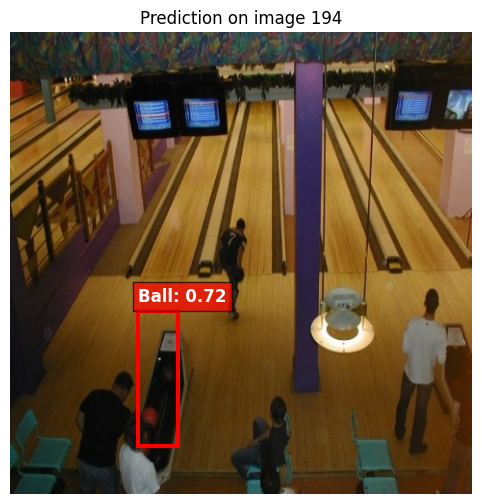

In [ ]:
import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(val_dataset) - 1)
img_tensor, _ = val_dataset[idx]

model.eval()
with torch.no_grad():
    output = model([img_tensor.to(device)])[0]

if len(output["scores"]) > 0:
    best_idx = output["scores"].argmax().item()
    box = output["boxes"][best_idx].cpu().numpy()
    score = output["scores"][best_idx].cpu().item()
else:
    box = None
    score = 0.0

img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img_show = img_np * std + mean
img_show = np.clip(img_show, 0, 1)

plt.figure(figsize=(8, 6))
plt.imshow(img_show)

if box is not None:
    x1, y1, x2, y2 = box
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                      fill=False, color='red', linewidth=3))
    plt.text(x1, y1 - 10, f"Ball: {score:.2f}",
             color='white', fontsize=12, weight='bold',
             bbox=dict(facecolor='red', alpha=0.7))

plt.axis('off')
plt.title(f"Prediction on image {idx}")
plt.show()

Далее попробовал добавить аугментации, затрагивающие ground-truth box

In [ ]:
trained_model = train_model(model, train_loader, val_loader, device, optimizer, num_epochs=5)
map_result = evaluate_map_on_val(trained_model, val_loader, device)


===== Epoch 1/5 =====


Train 1: 100%|██████████| 359/359 [02:25<00:00,  2.47it/s]


Train loss: 0.337498

===== Epoch 2/5 =====


Train 2: 100%|██████████| 359/359 [02:25<00:00,  2.47it/s]


Train loss: 0.326214

===== Epoch 3/5 =====


Train 3: 100%|██████████| 359/359 [02:25<00:00,  2.47it/s]


Train loss: 0.334475

===== Epoch 4/5 =====


Train 4: 100%|██████████| 359/359 [02:24<00:00,  2.48it/s]


Train loss: 0.325515

===== Epoch 5/5 =====


Train 5: 100%|██████████| 359/359 [02:24<00:00,  2.48it/s]


Train loss: 0.327426


Evaluating mAP on Val: 100%|██████████| 113/113 [00:20<00:00,  5.55it/s]



 mAP @ IoU=0.5: 0.0868


Качество заметно уменьшилось. Пробую менять оптимизатор и количество эпох <br>
Оптимизатор - Adam, lr=0.001, 25% от датасета, 10 эпох

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=None,
    num_classes=2
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0005
)

In [ ]:
trained_model = train_model(model, train_loader, val_loader, device, optimizer, num_epochs=10)
map_result = evaluate_map_on_val(trained_model, val_loader, device)


===== Epoch 1/10 =====


Train 1: 100%|██████████| 359/359 [02:26<00:00,  2.45it/s]


Train loss: 0.594397

===== Epoch 2/10 =====


Train 2: 100%|██████████| 359/359 [02:24<00:00,  2.48it/s]


Train loss: 0.383721

===== Epoch 3/10 =====


Train 3: 100%|██████████| 359/359 [02:24<00:00,  2.49it/s]


Train loss: 0.406461

===== Epoch 4/10 =====


Train 4: 100%|██████████| 359/359 [02:23<00:00,  2.49it/s]


Train loss: 5.373122

===== Epoch 5/10 =====


Train 5: 100%|██████████| 359/359 [02:20<00:00,  2.56it/s]


Train loss: 80.389229

===== Epoch 6/10 =====


Train 6: 100%|██████████| 359/359 [02:20<00:00,  2.56it/s]


Train loss: 324.774198

===== Epoch 7/10 =====


Train 7: 100%|██████████| 359/359 [02:19<00:00,  2.57it/s]


Train loss: 124.884234

===== Epoch 8/10 =====


Train 8: 100%|██████████| 359/359 [02:19<00:00,  2.58it/s]


Train loss: 0.358169

===== Epoch 9/10 =====


Train 9: 100%|██████████| 359/359 [02:18<00:00,  2.58it/s]


Train loss: 0.307879

===== Epoch 10/10 =====


Train 10: 100%|██████████| 359/359 [02:19<00:00,  2.58it/s]


Train loss: 0.272519


Evaluating mAP on Val: 100%|██████████| 113/113 [00:19<00:00,  5.71it/s]


 mAP @ IoU=0.5: 0.0000


Увеличил количество данных для трейна в два раза <br>
Оптимизатор - AdamW, lr=0.001, 50% от датасета, изменяющие аугментации, 10 эпох

In [11]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    weights=None,
    num_classes=2
).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=0.0005
)

In [12]:
trained_model = train_model(model, train_loader, val_loader, device, optimizer, num_epochs=10)
map_result = evaluate_map_on_val(trained_model, val_loader, device)


===== Epoch 1/10 =====


Train 1: 100%|██████████| 719/719 [04:48<00:00,  2.49it/s]


Train loss: 0.518129

===== Epoch 2/10 =====


Train 2: 100%|██████████| 719/719 [04:27<00:00,  2.69it/s]


Train loss: 37393.163814

===== Epoch 3/10 =====


Train 3: 100%|██████████| 719/719 [04:36<00:00,  2.60it/s]


Train loss: 58786106483.013039

===== Epoch 4/10 =====


Train 4: 100%|██████████| 719/719 [04:37<00:00,  2.59it/s]


Train loss: 0.433476

===== Epoch 5/10 =====


Train 5: 100%|██████████| 719/719 [04:37<00:00,  2.59it/s]


Train loss: 0.309220

===== Epoch 6/10 =====


Train 6: 100%|██████████| 719/719 [04:37<00:00,  2.59it/s]


Train loss: 0.259014

===== Epoch 7/10 =====


Train 7: 100%|██████████| 719/719 [04:37<00:00,  2.60it/s]


Train loss: 0.253340

===== Epoch 8/10 =====


Train 8: 100%|██████████| 719/719 [04:36<00:00,  2.60it/s]


Train loss: 0.396312

===== Epoch 9/10 =====


Train 9: 100%|██████████| 719/719 [04:36<00:00,  2.60it/s]


Train loss: 0.420935

===== Epoch 10/10 =====


Train 10: 100%|██████████| 719/719 [04:36<00:00,  2.60it/s]


Train loss: 0.418692


Evaluating mAP on Val: 100%|██████████| 113/113 [00:19<00:00,  5.74it/s]


 mAP @ IoU=0.5: 0.0000


При использовании Adam и AdamW обучение получилось нестабильным. <br>
Пробую  mobilenet_v3_large вместо ResNet-50, возврашаюсь к SGD, lr 0.0005, 10 эпох, половина датасета

In [11]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights_backbone=None,
    num_classes=2
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=0.0005
)

trained_model = train_model(model, train_loader, val_loader, device, optimizer, num_epochs=10)
map_result = evaluate_map_on_val(trained_model, val_loader, device)


===== Epoch 1/10 =====


Train 1: 100%|██████████| 719/719 [01:51<00:00,  6.45it/s]


Train loss: 0.930238

===== Epoch 2/10 =====


Train 2: 100%|██████████| 719/719 [01:46<00:00,  6.76it/s]


Train loss: 0.773552

===== Epoch 3/10 =====


Train 3: 100%|██████████| 719/719 [01:46<00:00,  6.77it/s]


Train loss: 0.737796

===== Epoch 4/10 =====


Train 4: 100%|██████████| 719/719 [01:46<00:00,  6.72it/s]


Train loss: 0.722744

===== Epoch 5/10 =====


Train 5: 100%|██████████| 719/719 [01:46<00:00,  6.74it/s]


Train loss: 0.719391

===== Epoch 6/10 =====


Train 6: 100%|██████████| 719/719 [01:46<00:00,  6.77it/s]


Train loss: 0.703373

===== Epoch 7/10 =====


Train 7: 100%|██████████| 719/719 [01:46<00:00,  6.76it/s]


Train loss: 0.700165

===== Epoch 8/10 =====


Train 8: 100%|██████████| 719/719 [01:46<00:00,  6.72it/s]


Train loss: 0.690666

===== Epoch 9/10 =====


Train 9: 100%|██████████| 719/719 [01:46<00:00,  6.72it/s]


Train loss: 0.690246

===== Epoch 10/10 =====


Train 10: 100%|██████████| 719/719 [01:46<00:00,  6.75it/s]


Train loss: 0.681350


Evaluating mAP on Val: 100%|██████████| 113/113 [00:06<00:00, 18.37it/s]



 mAP @ IoU=0.5: 0.1331


Увеличиваю количество эпох<br>
Пробую mobilenet_v3_large, SGD lr 0.0001, 15 эпох, полный датасет

In [16]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights_backbone=None,
    num_classes=2
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.0001,
    momentum=0.9,
    weight_decay=0.0005
)

trained_model = train_model(model, train_loader, val_loader, device, optimizer, num_epochs=15)
map_result = evaluate_map_on_val(trained_model, val_loader, device)


===== Epoch 1/15 =====


Train 1: 100%|██████████| 1438/1438 [03:39<00:00,  6.57it/s]


Train loss: 1.159719

===== Epoch 2/15 =====


Train 2: 100%|██████████| 1438/1438 [03:38<00:00,  6.59it/s]


Train loss: 0.958578

===== Epoch 3/15 =====


Train 3: 100%|██████████| 1438/1438 [03:37<00:00,  6.60it/s]


Train loss: 0.810156

===== Epoch 4/15 =====


Train 4: 100%|██████████| 1438/1438 [03:36<00:00,  6.66it/s]


Train loss: 0.782910

===== Epoch 5/15 =====


Train 5: 100%|██████████| 1438/1438 [03:34<00:00,  6.69it/s]


Train loss: 0.791618

===== Epoch 6/15 =====


Train 6: 100%|██████████| 1438/1438 [03:34<00:00,  6.70it/s]


Train loss: 0.787549

===== Epoch 7/15 =====


Train 7: 100%|██████████| 1438/1438 [03:35<00:00,  6.67it/s]


Train loss: 0.777780

===== Epoch 8/15 =====


Train 8: 100%|██████████| 1438/1438 [03:34<00:00,  6.71it/s]


Train loss: 0.777262

===== Epoch 9/15 =====


Train 9: 100%|██████████| 1438/1438 [03:34<00:00,  6.70it/s]


Train loss: 0.768187

===== Epoch 10/15 =====


Train 10: 100%|██████████| 1438/1438 [03:34<00:00,  6.70it/s]


Train loss: 0.755279

===== Epoch 11/15 =====


Train 11: 100%|██████████| 1438/1438 [03:35<00:00,  6.69it/s]


Train loss: 0.746054

===== Epoch 12/15 =====


Train 12: 100%|██████████| 1438/1438 [03:35<00:00,  6.67it/s]


Train loss: 0.736396

===== Epoch 13/15 =====


Train 13: 100%|██████████| 1438/1438 [03:34<00:00,  6.69it/s]


Train loss: 0.737791

===== Epoch 14/15 =====


Train 14: 100%|██████████| 1438/1438 [03:35<00:00,  6.67it/s]


Train loss: 0.727863

===== Epoch 15/15 =====


Train 15: 100%|██████████| 1438/1438 [03:34<00:00,  6.71it/s]


Train loss: 0.725990


Evaluating mAP on Val: 100%|██████████| 113/113 [00:06<00:00, 17.26it/s]



 mAP @ IoU=0.5: 0.0733


Метрика заметно снизилась, пробую прогнать на полном датасете и убрать аугментации, не затрагивающие ground_truth box <br>
Пробую mobilenet_v3_large, SGD lr 0.0001, 15 эпох, полный датасет без изменяющих аугментаций

In [21]:
trained_model = train_model(model, train_loader, val_loader, device, optimizer, num_epochs=15)
map_result = evaluate_map_on_val(trained_model, val_loader, device)


===== Epoch 1/15 =====


Train 1: 100%|██████████| 1438/1438 [03:33<00:00,  6.75it/s]


Train loss: 0.708718

===== Epoch 2/15 =====


Train 2: 100%|██████████| 1438/1438 [03:32<00:00,  6.77it/s]


Train loss: 0.692390

===== Epoch 3/15 =====


Train 3: 100%|██████████| 1438/1438 [03:32<00:00,  6.77it/s]


Train loss: 0.684612

===== Epoch 4/15 =====


Train 4: 100%|██████████| 1438/1438 [03:32<00:00,  6.76it/s]


Train loss: 0.674557

===== Epoch 5/15 =====


Train 5: 100%|██████████| 1438/1438 [03:32<00:00,  6.77it/s]


Train loss: 0.666325

===== Epoch 6/15 =====


Train 6: 100%|██████████| 1438/1438 [03:32<00:00,  6.76it/s]


Train loss: 0.658495

===== Epoch 7/15 =====


Train 7: 100%|██████████| 1438/1438 [03:32<00:00,  6.75it/s]


Train loss: 0.652964

===== Epoch 8/15 =====


Train 8: 100%|██████████| 1438/1438 [03:32<00:00,  6.77it/s]


Train loss: 0.647038

===== Epoch 9/15 =====


Train 9: 100%|██████████| 1438/1438 [03:32<00:00,  6.76it/s]


Train loss: 0.644377

===== Epoch 10/15 =====


Train 10: 100%|██████████| 1438/1438 [03:32<00:00,  6.76it/s]


Train loss: 0.633525

===== Epoch 11/15 =====


Train 11: 100%|██████████| 1438/1438 [03:32<00:00,  6.76it/s]


Train loss: 0.630044

===== Epoch 12/15 =====


Train 12: 100%|██████████| 1438/1438 [03:33<00:00,  6.75it/s]


Train loss: 0.623619

===== Epoch 13/15 =====


Train 13: 100%|██████████| 1438/1438 [03:33<00:00,  6.75it/s]


Train loss: 0.620853

===== Epoch 14/15 =====


Train 14: 100%|██████████| 1438/1438 [03:34<00:00,  6.70it/s]


Train loss: 0.612516

===== Epoch 15/15 =====


Train 15: 100%|██████████| 1438/1438 [03:41<00:00,  6.50it/s]


Train loss: 0.608351


Evaluating mAP on Val: 100%|██████████| 113/113 [00:06<00:00, 18.32it/s]



 mAP @ IoU=0.5: 0.1485


Удалось немного поднять mAP, но лосс уменьшается медленно <br>
Попытка взять предобученный датасет на четверти данных и посмотреть лосс

In [26]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights_backbone=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1,
    num_classes=2
).to(device)

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.0001,
    momentum=0.9,
    weight_decay=0.0005
)

trained_model = train_model(model, train_loader, val_loader, device, optimizer, num_epochs=10)
map_result = evaluate_map_on_val(trained_model, val_loader, device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 130MB/s] 



===== Epoch 1/10 =====


Train 1: 100%|██████████| 359/359 [00:37<00:00,  9.47it/s]


Train loss: 1.126629

===== Epoch 2/10 =====


Train 2: 100%|██████████| 359/359 [00:39<00:00,  9.11it/s]


Train loss: 0.842634

===== Epoch 3/10 =====


Train 3: 100%|██████████| 359/359 [00:37<00:00,  9.48it/s]


Train loss: 0.752940

===== Epoch 4/10 =====


Train 4: 100%|██████████| 359/359 [00:38<00:00,  9.34it/s]


Train loss: 0.732389

===== Epoch 5/10 =====


Train 5: 100%|██████████| 359/359 [00:38<00:00,  9.43it/s]


Train loss: 0.716153

===== Epoch 6/10 =====


Train 6: 100%|██████████| 359/359 [00:38<00:00,  9.42it/s]


Train loss: 0.708955

===== Epoch 7/10 =====


Train 7: 100%|██████████| 359/359 [00:38<00:00,  9.43it/s]


Train loss: 0.699691

===== Epoch 8/10 =====


Train 8: 100%|██████████| 359/359 [00:37<00:00,  9.52it/s]


Train loss: 0.719711

===== Epoch 9/10 =====


Train 9: 100%|██████████| 359/359 [00:37<00:00,  9.50it/s]


Train loss: 0.720528

===== Epoch 10/10 =====


Train 10: 100%|██████████| 359/359 [00:37<00:00,  9.48it/s]


Train loss: 0.721617


Evaluating mAP on Val: 100%|██████████| 113/113 [00:06<00:00, 16.97it/s]



 mAP @ IoU=0.5: 0.1542


На предобученной модели немного возрос mAP (результат для четверти датасета)

# **Итоги:**

Метрика mAP получилась довольно низкой: максимальное значение 0.1542 для предобученной модели. Значение не сильно увеличилось по сравнению с необученной: 0.1485 для mobilenet_v3_large, SGD lr 0.0001, 15 эпох, полный датасет без изменяющих аугментаций. <br>
Пути для улучшения решения:


1.   Не использовать аугментации, затрагивающие изменение ground-truth bounding box: скорее всего такие аугментации только усложняют обучение модели на небольшом количестве данных
2.   Пробовать использовать другую модель для обучения.
3.   Внедрить scheduler
4.   В качестве backbone использовать ResNet-18

